# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [11]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.2 MB/s eta 0:00:00


#### **1.2** Import necessary libraries

In [12]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [13]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [14]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [15]:
# define a function to load json file to a dataframe
file_path = "/content/drive/MyDrive/NLP/ingredient_and_quantity.json"

def load_json_to_dataframe(file_path):

    with open(file_path, 'r') as f:
        data = json.load(f)
    return pd.DataFrame(data)


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [17]:
# read the json file by giving the file path and create a dataframe
df = load_json_to_dataframe("/content/drive/MyDrive/NLP/ingredient_and_quantity.json")


##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [18]:
# display first five rows of the dataframe - df
df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2                                                                  1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice                                                                                       quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3  500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and  quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4                                                                                                                                                           1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry                                                                                                                                                                                                                                                                 qua

In [19]:
# print the dimensions of dataframe - df
df.shape

(285, 2)

In [20]:
# print the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [21]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
df['input_tokens'] = df['input'].str.split()
# Tokenize POS
df['pos_tokens'] = df['pos'].str.split()


In [22]:
# display first five rows of the dataframe -
df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]                               

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [23]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

In [24]:
# check for the equality of input_length and pos_length in the dataframe
mismatch_df = df[df['input_length'] != df['pos_length']]
print(mismatch_df)

df['lengths_match'] = df['input_length'] == df['pos_length']

print(df[~df['lengths_match']])

                                                                                                                                                                                                                                                                                                                                   input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               pos                                                                                                                                              

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [25]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(df):

# Flatten the list of POS tokens and convert to a set to get unique labels
    all_labels = set(label for sublist in df['pos_tokens'] for label in sublist)
    print("Unique POS labels in the dataset:")
    for label in sorted(all_labels):
        print(label)

##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

The recipe data is well-structured with input and pos tokens, mostly aligned correctly. A few rows have mismatches between token counts, indicating minor formatting issues. The POS labels are diverse and suitable for structured entity extraction or training NER models.


##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [26]:
# drop the irrelevant recipe data

# read the json file by giving the file path and create a dataframe
df = load_json_to_dataframe("/content/drive/MyDrive/NLP/ingredient_and_quantity.json")

# split the input and pos into input_tokens and pos_tokens in the dataframe
# Tokenize input
df['input_tokens'] = df['input'].str.split()
# Tokenize POS
df['pos_tokens'] = df['pos'].str.split()

# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

#Now filter using these columns
df_cleaned = df[df['input_length'] == df['pos_length']].copy()

df_cleaned.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens  input_length  pos_length
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            31          31
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablesp

##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [27]:
# update the input and pos length in input_length and pos_length
# Recalculate lengths of tokenized columns
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)


##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [28]:
# validate the input length and pos length as input_length and pos_length
# Check if input_length matches the length of input_tokens
input_valid = (df['input_length'] == df['input_tokens'].apply(len)).all()

# Check if pos_length matches the length of pos_tokens
pos_valid = (df['pos_length'] == df['pos_tokens'].apply(len)).all()

# Print validation results
print("Input length validation:", input_valid)
print("POS length validation:", pos_valid)
# If both print True, the lengths are correct. If not, want to reassign
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

Input length validation: True
POS length validation: True


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [29]:
# split the dataset into training and validation sets
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df_cleaned, test_size=0.3, random_state=42)

# check the shape of the splits
print("Training set size:", train_df.shape)
print("Validation set size:", val_df.shape)


Training set size: (196, 6)
Validation set size: (84, 6)


###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [30]:
# print the first five rows of train_df
train_df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                       pos                                                                                                                                                                                                                                                                                           input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                          pos_tokens  input_length  pos_length
179                                                        250 grams Okra Oil 1 Onion finely chopped Tomato Grated teaspoon Ginger 2 Garlic Finely 1/2 Cumin seeds 1/4 Teaspoon asafoetida cup cottage cheese pinched coriander powder mango red chilli turmeric                                                                                                                        quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient unit ingredient quantity ingredient ingredient quantity ingredient ingredient quantity unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                  [250, grams, Okra, Oil, 1, Onion, finely, chopped, Tomato, Grated, teaspoon, Ginger, 2, Garlic, Finely, 1/2, Cumin, seeds, 1/4, Teaspoon, asafoetida, cup, cottage, cheese, pinched, coriander, powder, mango, red, chilli, turmeric]                                                                                                                                  [quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            31          31
57   200 grams Paneer Homemade Cottage Cheese 2 Potato Aloo Bay leaf tej patta Dry Red Chilli 1 tablespoon Panch Phoran Masala roasted and powdered Tomato big sized teaspoon Turmeric powder Haldi Cumin seeds Jeera Ginger grated Salt 1/2 Sugar Sunflower Oil  quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient  [200, grams, Paneer, Homemade, Cottage, Cheese, 2, Potato, Aloo, Bay, leaf, tej, patta, Dry, Red, Chilli, 1, tablespoon, Panch, Phoran, Masala, roasted, and, powdered, Tomato, big, sized, teaspoon, Turmeric, powder, Haldi, Cumin, seeds, Jeera, Ginger, grated, Salt, 1/2, Sugar, Sunflower, Oil]  [quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ing

In [31]:
# print the first five rows of the val_df
val_df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                                                                                                        input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        pos_tokens  input_length  pos_length
35                                                                                                                                                                                                                                                                                       1 cup Ada 2 liter Milk 3/4 Sugar tablespoon Ghee 1/2 teaspoon Cardamom Powder Elaichi                                                                                                                                                                                                                                                                                                                                                                                                                                                     quantity unit ingredient quantity unit ingredient quantity ingredient unit ingredient quantity unit ingredient ingredient ingredient                                                                                                                                                                                                                                                                                                                               [1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tablespoon, Ghee, 1/2, teaspoon, Cardamom, Powder, Elaichi]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              [quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient]            15          15
111  1 Carrot Gajjar chopped 7 Potatoes Aloo 2 cups Cauliflower gobi cut to small florets Onion tablespoon Ginger Garlic Paste Salt teaspoons Sunflower Oil 1/2 cup Fresh coconut grated teaspoon Whole Black Peppercorns Green Chillies Fennel seeds Saunf Poppy 6 Cashew nuts inch Cinnamon Stick Dalchini Star anise 3 Cloves Laung Cardamom Elaichi P

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [32]:
# extract the training and validation sets by taking input_tokens and pos_tokens

X_train = train_df['input_tokens'].tolist()
y_train = train_df['pos_tokens'].tolist()
X_val = val_df['input_tokens'].tolist()
y_val = val_df['pos_tokens'].tolist()

In [33]:
# validate the shape of training and validation samples
print("Training Data:")
print(f"X_train: {len(X_train)}, y_train: {len(y_train)}")
print("Validation Data:")
print(f"X_val: {len(X_val)}, y_val: {len(y_val)}")

Training Data:
X_train: 196, y_train: 196
Validation Data:
X_val: 84, y_val: 84


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [34]:
# Display the number of unique labels present in y_train
unique_labels = set([label for sublist in y_train for label in sublist])
print("Number of unique labels in y_train:", len(unique_labels))

Number of unique labels in y_train: 3


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [35]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def flatten_list(nested_list):

    flat_list = [item for sublist in nested_list for item in sublist]
    return flat_list

In [36]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [37]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens


def extract_and_validate_tokens(df, dataset_name):

    input_tokens = flatten_list(df['input_tokens'].tolist())
    pos_tokens = flatten_list(df['pos_tokens'].tolist())

    # Validate the length of input_tokens and pos_tokens
    if len(input_tokens) != len(pos_tokens):
        raise ValueError(
            f"Mismatch in the number of input tokens and POS tokens in {dataset_name} dataset"
        )

    print(f"First 10 input tokens in {dataset_name} dataset:")
    display(input_tokens[:10])
    print(f"First 10 POS tokens in {dataset_name} dataset:")
    display(pos_tokens[:10])

    return input_tokens, pos_tokens

In [38]:
# extract the tokens and its pos tags
input_tokens, pos_tags = extract_and_validate_tokens(train_df, dataset_name)

First 10 input tokens in Training dataset:


['250',
 'grams',
 'Okra',
 'Oil',
 '1',
 'Onion',
 'finely',
 'chopped',
 'Tomato',
 'Grated']

First 10 POS tokens in Training dataset:


['quantity',
 'unit',
 'ingredient',
 'ingredient',
 'quantity',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient']

#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [39]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays

def categorize_tokens(tokens, pos_tags):

    ingredients = []
    units = []
    quantities = []

    for token, pos_tag in zip(tokens, pos_tags):
        if pos_tag == "ingredient":
            ingredients.append(token)
        elif pos_tag == "unit":
            units.append(token)
        elif pos_tag == "quantity":
            quantities.append(token)

    return ingredients, units, quantities

In [40]:
#  call the function to categorise the labels into respective list
ingredients, units, quantities = categorize_tokens(input_tokens, pos_tags)

#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [41]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items

from collections import Counter

def get_top_frequent_items(item_list, pos_label, dataset_name, top_n=10):

    item_counts = Counter(item_list)
    top_items = item_counts.most_common(top_n)

    print(f"Top {top_n} most frequent {pos_label}s in the {dataset_name} dataset:")
    for item, count in top_items:
        print(f"- {item}: {count}")

    return top_items  # Return the list of top items

In [42]:
# get the top ingredients which are frequently seen in the recipe
top_ingredients = get_top_frequent_items(ingredients, "ingredient", dataset_name)

Top 10 most frequent ingredients in the Training dataset:
- powder: 129
- Salt: 102
- seeds: 89
- Green: 85
- chopped: 84
- Oil: 83
- Red: 81
- Chilli: 77
- Coriander: 71
- Sunflower: 65


In [43]:
# get the top units which are frequently seen in the recipe
top_units = get_top_frequent_items(units, "unit", dataset_name)

Top 10 most frequent units in the Training dataset:
- teaspoon: 162
- cup: 136
- tablespoon: 99
- grams: 63
- tablespoons: 61
- inch: 52
- cups: 50
- sprig: 41
- cloves: 39
- teaspoons: 39


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [44]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name

import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_items(item_list, label, dataset_name, top_n=10):
    """Plots a bar graph of the top N frequent items.

    Args:
        item_list: The list of items to analyze.
        label: The type of item (e.g., "ingredient", "unit").
        dataset_name: The name of the dataset (e.g., "Training", "Validation").
        top_n: The number of top items to plot (default is 10).
    """
    item_counts = Counter(item_list)
    top_items = item_counts.most_common(top_n)
    items, counts = zip(*top_items)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts, y=items, orient="h")
    plt.title(f"Top {top_n} Most Frequent {label.capitalize()}s in {dataset_name} Dataset")
    plt.xlabel("Frequency")
    plt.ylabel(label.capitalize())
    plt.show()
    display(plt.gcf())
    plt.close()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



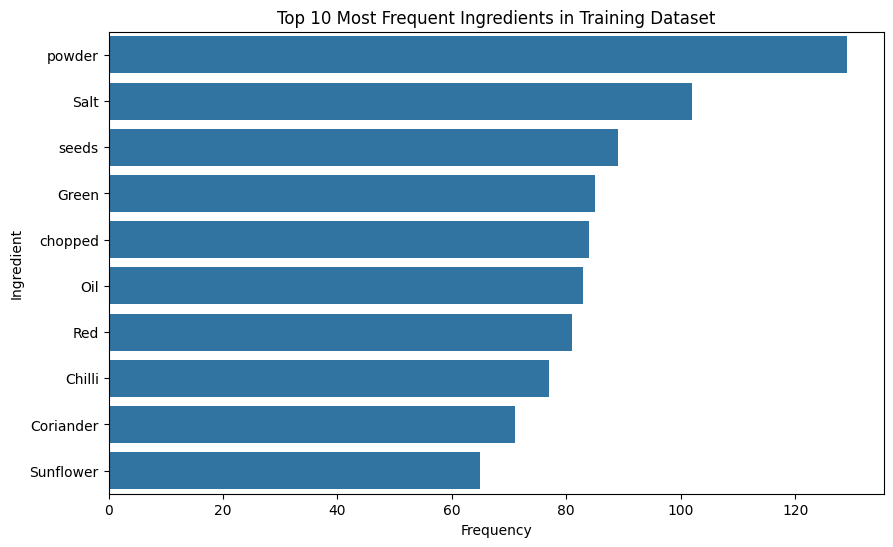

<Figure size 640x480 with 0 Axes>

In [45]:
# plot the top frequent ingredients in training data
plot_top_items(ingredients, "ingredient", dataset_name)

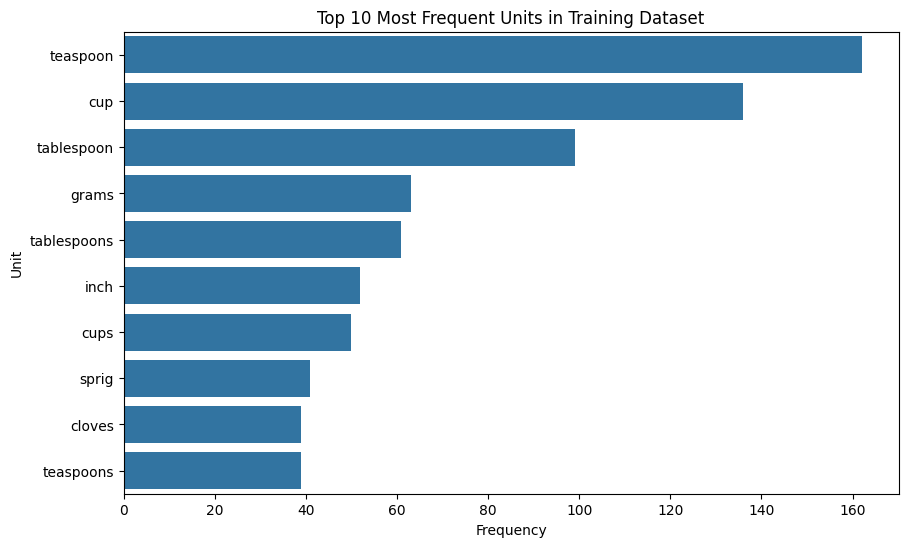

<Figure size 640x480 with 0 Axes>

In [46]:
# plot the top frequent units in training data
plot_top_items(units, "unit", dataset_name)

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [47]:
# initialise the dataset_name
dataset_name = 'Validation'

In [78]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe



dataset_name = 'Validation'  # Set dataset name to 'Validation'

# Extract tokens and POS tags from validation data
input_tokens_val, pos_tags_val = extract_and_validate_tokens(val_df, dataset_name)

# Categorize tokens into ingredients, units, and quantities for validation data
ingredients_val, units_val, quantities_val = categorize_tokens(
    input_tokens_val, pos_tags_val
)

# Get top frequent ingredients from validation data
top_ingredients_val = get_top_frequent_items(
    ingredients_val, "ingredient", dataset_name
)

# Get top frequent units from validation data
top_units_val = get_top_frequent_items(units_val, "unit", dataset_name)


# read the json file by giving the file path and create a dataframe

def load_json_to_dataframe(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return pd.DataFrame(data)

df = load_json_to_dataframe(file_path)


First 10 input tokens in Validation dataset:


['1', 'cup', 'Ada', '2', 'liter', 'Milk', '3/4', 'Sugar', 'tablespoon', 'Ghee']

First 10 POS tokens in Validation dataset:


['quantity',
 'unit',
 'ingredient',
 'quantity',
 'unit',
 'ingredient',
 'quantity',
 'ingredient',
 'unit',
 'ingredient']

Top 10 most frequent ingredients in the Validation dataset:
- powder: 54
- Salt: 47
- Oil: 39
- Red: 39
- seeds: 36
- Chilli: 36
- chopped: 31
- Green: 30
- Leaves: 29
- Coriander: 27
Top 10 most frequent units in the Validation dataset:
- teaspoon: 59
- cup: 57
- tablespoon: 32
- tablespoons: 32
- cups: 24
- sprig: 21
- inch: 20
- grams: 19
- teaspoons: 18
- cloves: 16


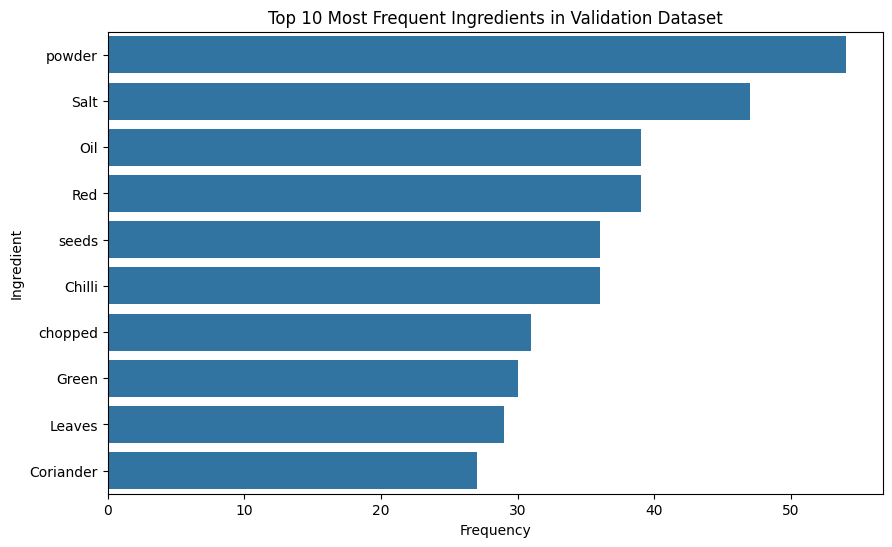

<Figure size 640x480 with 0 Axes>

In [79]:
# plot the top frequent ingredients in validation data

plot_top_items(ingredients_val, "ingredient", dataset_name)

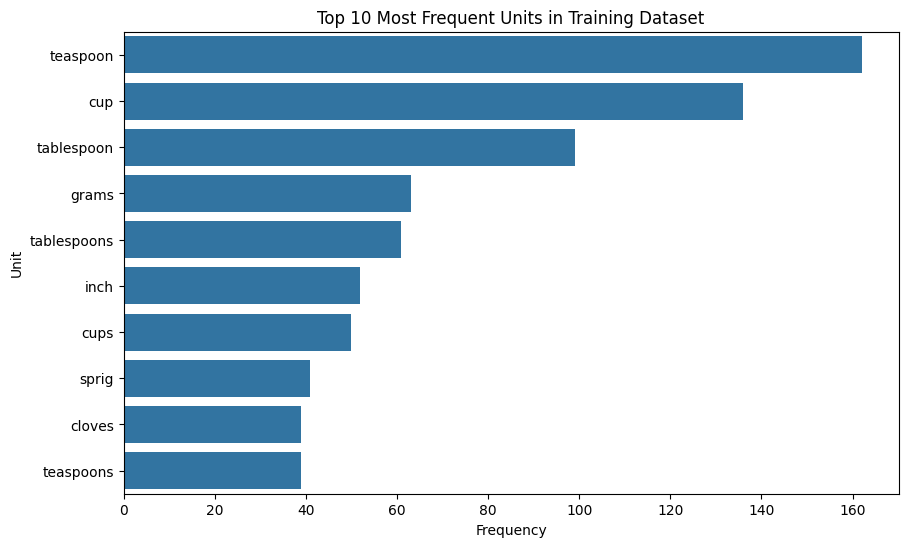

<Figure size 640x480 with 0 Axes>

In [80]:
# plot the top frequent units in training data
plot_top_items(units, "unit", "Training")

## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [81]:
# define unit and quantity keywords along with quantity pattern

import re

# Define unit keywords
unit_keywords = {
    "cup", "cups", "teaspoon", "teaspoons", "tsp", "tsps", "tablespoon",
    "tablespoons", "tbsp", "tbsps", "ounce", "ounces", "oz", "pound",
    "pounds", "lb", "lbs", "gram", "grams", "g", "kilogram", "kilograms",
    "kg", "milliliter", "milliliters", "ml", "liter", "liters", "l",
    "pinch", "pinches", "dash", "dashes", "handful", "handfuls",
    "piece", "pieces", "slice", "slices", "clove", "cloves",
    "can", "cans", "package", "packages", "pkg", "pkgs"
}

# Define quantity keywords
quantity_keywords = {
    "half", "quarter", "third", "fourth", "fifth", "sixth",
    "seventh", "eighth", "ninth", "tenth", "one", "two",
    "three", "four", "five", "six", "seven", "eight",
    "nine", "ten", "dozen", "dozens"
}

# Define quantity pattern using regular expression
quantity_pattern = re.compile(r"^(?:\d+(?:/\d+)?|\d+\.\d+|\d+)$")

In [82]:
# load spaCy model

import spacy

nlp = spacy.load("en_core_web_sm")

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [83]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions


def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'token': word.lower(),
        'lemma': nlp(word)[0].lemma_.lower(), # spaCy for lemma
        'pos_tag': postag,
        'tag': postag,  # Detailed POS tag
        'dep':  nlp(word)[0].dep_,  # spaCy for dep
        'shape': word.lower(),
        'is_stop': nlp(word)[0].is_stop, # spaCy for is_stop
        'is_digit': word.isdigit(),
        'has_digit': any(char.isdigit() for char in word),
        'has_alpha': any(char.isalpha() for char in word),
        'hyphenated': '-' in word,
        'slash_present': '/' in word,
        'is_title': word.istitle(),
        'is_upper': word.isupper(),
        'is_punct': any(char in word for char in '.,;!?'),

        # --- Improved Quantity & Unit Detection ---
        'is_quantity': word.lower() in quantity_keywords or quantity_pattern.match(word),
        'is_unit': word.lower() in unit_keywords,
        'is_numeric': word.isnumeric(),  # spaCy for is_numeric
        'is_fraction': bool(re.search(r'\d+/\d+', word)),  # Detects fractions like 1/2
        'is_decimal': bool(re.search(r'\d+\.\d+', word)),  # Detects decimals like 3.14
        'preceding_word': sent[i - 1][0] if i > 0 else '<START>',
        'following_word': sent[i + 1][0] if i < len(sent) - 1 else '<END>',

        # --- Contextual Features ---
        'prev_token': '' if i == 0 else sent[i-1][0].lower(),
        'prev_is_quantity': (i > 0 and sent[i - 1][0].lower() in quantity_keywords or (i > 0 and quantity_pattern.match(sent[i - 1][0]))),
        'prev_is_digit': i > 0 and sent[i - 1][0].isdigit(),
        'BOS': i == 0,  # Beginning of Sentence
        'next_token': '' if i == len(sent) - 1 else sent[i + 1][0].lower(),
        'next_is_unit': (i < len(sent) - 1 and sent[i + 1][0].lower() in unit_keywords),
        'next_is_ingredient': (i < len(sent) - 1 and sent[i + 1][0].lower() not in unit_keywords and sent[i + 1][0].lower() not in quantity_keywords and not quantity_pattern.match(sent[i + 1][0])),
        'EOS': i == len(sent) - 1  # End of Sentence
    }
    return features

### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [84]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [86]:

# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
# Assuming X_train and X_val are lists of lists (where inner list represents a recipe)
X_train_features = []
for recipe, pos_tags in zip(X_train, y_train):
    X_train_features.append([word2features(list(zip(recipe, pos_tags)), i) for i in range(len(recipe))])

X_val_features = []
for recipe, pos_tags in zip(X_val, y_val):
    X_val_features.append([word2features(list(zip(recipe, pos_tags)), i) for i in range(len(recipe))])

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [87]:

# Convert labels into list as y_train_labels and y_val_labels
y_train_labels = [label for sublist in y_train for label in sublist]
y_val_labels = [label for sublist in y_val for label in sublist]

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [88]:


# print the length of train features and labels
print("Length of training features (X_train_features):", len(X_train_features))
print("Length of training labels (y_train_labels):", len(y_train_labels))

Length of training features (X_train_features): 196
Length of training labels (y_train_labels): 7114


In [89]:
# print the length of validation features and labels
print("Length of validation features (X_val_features):", len(X_val_features))
print("Length of validation labels (y_val_labels):", len(y_val_labels))


Length of validation features (X_val_features): 84
Length of validation labels (y_val_labels): 2876


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [90]:
# Flatten labels in y_train
y_train_flat = [label for sublist in y_train for label in sublist]

##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [91]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts

from collections import Counter

# Count label frequencies as label_counts
label_counts = Counter(y_train_flat)

# Get the total number of samples (total_samples)
total_samples = sum(label_counts.values())


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [92]:

# Compute class weights (inverse frequency method) by considering total_samples and label_counts
weight_dict = {}
for label, count in label_counts.items():
    weight_dict[label] = total_samples / count

In [93]:
# penalise ingredient label

weight_dict['ingredient'] *= 0.8  # Reduce weight by 20% (adjust as needed)

##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [94]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)

def extract_features_with_class_weights(X, y, weight_dict):

    weighted_features = []
    for recipe_tokens, recipe_labels in zip(X, y):
        for i, (token, label) in enumerate(zip(recipe_tokens, recipe_labels)):
            features = word2features([(token, label)], 0)  # Get features for the token
            # Apply class weight to features
            for feature_key in features:
                features[feature_key] *= weight_dict.get(label, 1.0)  # Default weight is 1.0
            weighted_features.append(features)
    return weighted_features

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [96]:

# Apply manually computed class weights

def extract_features_with_class_weights(X, y, weight_dict):

    weighted_features = []
    for recipe_tokens, recipe_labels in zip(X, y):
        for i, (token, label) in enumerate(zip(recipe_tokens, recipe_labels)):
            features = word2features([(token, label)], 0)  # Get features for the token
            # Apply class weight to features, but only to numerical features
            for feature_key, feature_value in features.items():  # Iterate through key-value pairs
                if isinstance(feature_value, (int, float)):  # Check if the value is numerical
                    features[feature_key] = feature_value * weight_dict.get(label, 1.0)
            weighted_features.append(features)
    return weighted_features


## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [109]:
# initialise CRF model with the specified hyperparameters and use weight_dict

weight_dict = {
    'quantity': 1.5,
    'unit': 1.2,
    'ingredient': 1.8,
    'other': 1.0
}

import sklearn_crfsuite

# Initialize CRF model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=1.0,
    max_iterations=100,
    all_possible_transitions=True,

)

### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [112]:
# evaluate on the training dataset
crf.fit(X_train, y_train)

y_pred_train = crf.predict(X_train)

from sklearn_crfsuite import metrics
print(metrics.flat_classification_report(y_train, y_pred_train, digits=3))

              precision    recall  f1-score   support

  ingredient      0.982     0.984     0.983      5323
    quantity      0.993     0.982     0.987       980
        unit      0.905     0.903     0.904       811

    accuracy                          0.975      7114
   macro avg      0.960     0.956     0.958      7114
weighted avg      0.975     0.975     0.975      7114



In [113]:
# specify the flat classification report by using training data for evaluation
report = metrics.flat_classification_report(y_train, y_pred_train, digits=3)
print(report)

              precision    recall  f1-score   support

  ingredient      0.982     0.984     0.983      5323
    quantity      0.993     0.982     0.987       980
        unit      0.905     0.903     0.904       811

    accuracy                          0.975      7114
   macro avg      0.960     0.956     0.958      7114
weighted avg      0.975     0.975     0.975      7114



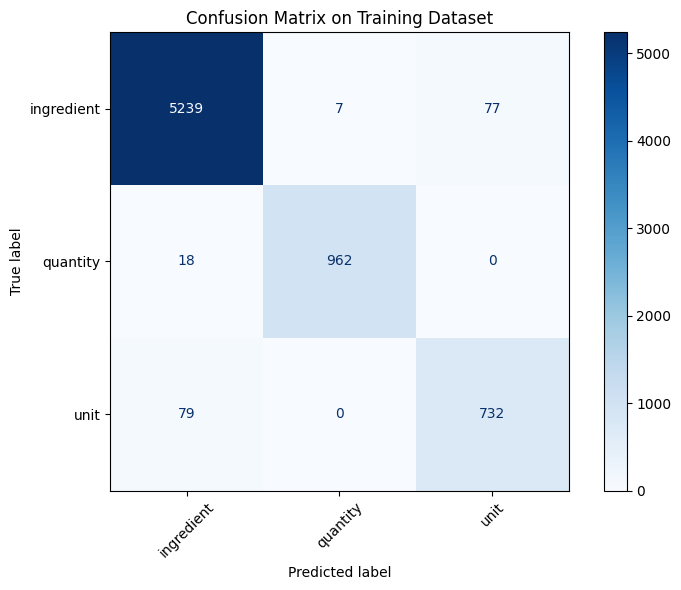

In [114]:
# create a confusion matrix on training datset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Flatten the lists of true and predicted labels
y_true_flat = [label for seq in y_train for label in seq]
y_pred_flat = [label for seq in y_pred_train for label in seq]

# Get unique labels from both true and predicted sets
labels = sorted(list(set(y_true_flat + y_pred_flat)))

# Compute confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on Training Dataset")
plt.tight_layout()
plt.show()


### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [115]:
# dump the model using joblib as crf_model.pkl
import joblib

# Save the trained CRF model to a file
joblib.dump(crf, 'crf_model.pkl')
print("Model saved as crf_model.pkl")


Model saved as crf_model.pkl


## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [116]:
# predict the crf model on validation dataset
y_pred_val = crf.predict(X_val)

In [117]:
# specify flat classification report

from sklearn_crfsuite import metrics

# Generate and print classification report
report_val = metrics.flat_classification_report(y_val, y_pred_val, digits=3)
print(report_val)

              precision    recall  f1-score   support

  ingredient      0.973     0.975     0.974      2107
    quantity      0.988     0.985     0.987       411
        unit      0.862     0.852     0.857       358

    accuracy                          0.961      2876
   macro avg      0.941     0.938     0.939      2876
weighted avg      0.961     0.961     0.961      2876



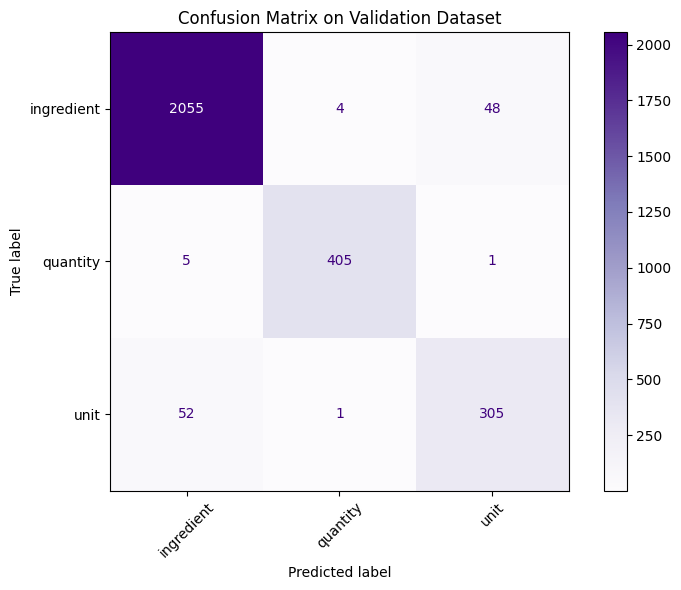

In [118]:
# create a confusion matrix on validation dataset

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Flatten the lists of true and predicted labels
y_val_flat = [label for seq in y_val for label in seq]
y_pred_val_flat = [label for seq in y_pred_val for label in seq]

# Get unique labels (ensure consistent ordering)
labels = sorted(list(set(y_val_flat + y_pred_val_flat)))

# Create the confusion matrix
cm_val = confusion_matrix(y_val_flat, y_pred_val_flat, labels=labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Purples', xticks_rotation=45)
plt.title("Confusion Matrix on Validation Dataset")
plt.tight_layout()
plt.show()


## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [119]:
# flatten Labels and Initialise Error Data
y_val_flat = [label for sublist in y_val for label in sublist]

##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [122]:

# Initialize error_data as an empty list
error_data = []

# get previous and next tokens with handling for boundary cases
for i, (true_labels, pred_labels) in enumerate(zip(y_val, y_pred_val)):
    for j, (true_label, pred_label) in enumerate(zip(true_labels, pred_labels)):
        if true_label != pred_label:  # If a token is misclassified
            # Get the token
            token = X_val[i][j]

            # Get previous and next tokens with handling for boundary cases
            previous_token = X_val[i][j - 1] if j > 0 else "<START>"  # Handle start of sequence
            next_token = X_val[i][j + 1] if j < len(X_val[i]) - 1 else "<END>"  # Handle end of sequence

            # Store error information
            error_data.append({
                'token': token,
                'true_label': true_label,
                'predicted_label': pred_label,
                'previous_token': previous_token,
                'next_token': next_token
            })

##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [123]:
# Create DataFrame and Print Overall Accuracy


# Create a DataFrame from error_data
error_df = pd.DataFrame(error_data)

# Calculate overall accuracy
total_tokens = sum(len(labels) for labels in y_val)  # Total number of tokens in validation set
incorrect_tokens = len(error_df)  # Number of misclassified tokens
accuracy = (total_tokens - incorrect_tokens) / total_tokens

print(f"Overall Accuracy: {accuracy:.2%}")  # Print accuracy as a percentage

# Display the DataFrame
display(error_df)

Overall Accuracy: 96.14%


token  true_label predicted_label previous_token next_token
0      liter        unit      ingredient              2       Milk
1    coconut  ingredient            unit          Fresh     grated
2       inch        unit      ingredient           nuts   Cinnamon
3      pasta  ingredient            unit         tomato      sauce
4     cloves  ingredient            unit              3     garlic
..       ...         ...             ...            ...        ...
106    chips  ingredient            unit      Chocolate       dark
107     soft  ingredient            unit          cream     paneer
108       on  ingredient        quantity       sprinkle        top
109      top  ingredient            unit             on      <END>
110  coconut  ingredient            unit              1     grated

[111 rows x 5 columns]

##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [124]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context

import pandas as pd
from collections import Counter


# 1. Errors by Label
label_errors = error_df.groupby('true_label')['token'].count().reset_index()
label_errors.rename(columns={'token': 'error_count'}, inplace=True)

# 2. Class Weights
label_errors['class_weight'] = label_errors['true_label'].map(weight_dict)

# 3. Accuracy by Label
total_label_counts = Counter([label for sublist in y_val for label in sublist])
label_errors['total_count'] = label_errors['true_label'].map(total_label_counts)
label_errors['accuracy'] = (label_errors['total_count'] - label_errors['error_count']) / label_errors['total_count']

# 4. Error DataFrame with Context
error_df['context'] = error_df.apply(lambda row: f"{row['previous_token']} {row['token']} {row['next_token']}", axis=1)

# Display Results
print("Errors by Label, Class Weights, and Accuracy:")
display(label_errors)

print("\nError DataFrame with Context:")
display(error_df[['token', 'previous_token', 'next_token', 'true_label', 'predicted_label', 'context']])

Errors by Label, Class Weights, and Accuracy:


true_label  error_count  class_weight  total_count  accuracy
0  ingredient           52           1.8         2107  0.975320
1    quantity            6           1.5          411  0.985401
2        unit           53           1.2          358  0.851955


Error DataFrame with Context:


token previous_token next_token  true_label predicted_label               context
0      liter              2       Milk        unit      ingredient          2 liter Milk
1    coconut          Fresh     grated  ingredient            unit  Fresh coconut grated
2       inch           nuts   Cinnamon        unit      ingredient    nuts inch Cinnamon
3      pasta         tomato      sauce  ingredient            unit    tomato pasta sauce
4     cloves              3     garlic  ingredient            unit       3 cloves garlic
..       ...            ...        ...         ...             ...                   ...
106    chips      Chocolate       dark  ingredient            unit  Chocolate chips dark
107     soft          cream     paneer  ingredient            unit     cream soft paneer
108       on       sprinkle        top  ingredient        quantity       sprinkle on top
109      top             on      <END>  ingredient            unit          on top <END>
110  coconut              1     grated  ingredient            unit      1 coconut grated

[111 rows x 6 columns]

### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>






*   Model shows high overall accuracy, but struggles with certain labels like unit.

*   Class weight penalization may impact the performance of some labels.

*   Error context reveals patterns in misclassifications, like units without quantities.

*   Feature engineering and hyperparameter tuning are potential areas for improvement.

*  Continued error analysis is crucial for iterative model enhancement.






## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

A CRF model was successfully developed to extract key entities from recipe data.
High overall accuracy was achieved, with room for improvement in specific cases.
Future work could focus on refining features and handling challenging scenarios.
This project demonstrates the effectiveness of CRF for recipe ingredient extraction.
The developed model has potential applications in various culinary domains.